In [8]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def tiff_to_numpy(input_folder):
    """
    Convert all TIFF images in the input_folder to numpy arrays.
    Returns a list of numpy arrays.
    """
    numpy_arrays = []

    for filename in os.listdir(input_folder):
        if filename.endswith('.tif') or filename.endswith('.tiff'):
            image_path = os.path.join(input_folder, filename)
            image = Image.open(image_path)
            
            # Convert the image to a numpy array
            image_array = np.array(image)
            numpy_arrays.append(image_array)

    return numpy_arrays

In [7]:
input_folder_train_images = "../raw_data/AerialImageDataset/train/images"
input_folder_train_solutions = "../raw_data/AerialImageDataset/train/gt"

In [ ]:
X_train = tiff_to_numpy(input_folder_train_images)

In [ ]:
len(X_train)

In [ ]:
plt.imshow(X_train[0])

In [ ]:
X_train_sizes = []

for im in X_train:
    size = im.shape
    X_train_sizes.append(size)

In [ ]:
X_train_sizes

In [ ]:
y_train = tiff_to_numpy(input_folder_train_solutions)

In [ ]:
y_train_sizes = []

for im in y_train:
    size = im.shape
    y_train_sizes.append(size)

In [ ]:
y_train_sizes

In [ ]:
normalized_X_train =[]

for im in X_train:
    normalized = im/255
    normalized_X_train.append(normalized)
    

In [ ]:
!pip install tensorflow-macos

In [9]:
import numpy as np
import os
from PIL import Image
from tensorflow.keras.utils import Sequence

class TIFImageGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, batch_size, img_size):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.image_filenames = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_filenames) // self.batch_size

    def __getitem__(self, index):
        batch_files = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        X = np.zeros((self.batch_size, *self.img_size, 3))  # 3 channels for RGB
        y = np.zeros((self.batch_size, *self.img_size, 1))  # 1 channel for grayscale
        
        for i, file in enumerate(batch_files):
            img_path = os.path.join(self.image_dir, file)
            mask_path = os.path.join(self.mask_dir, file)  # Assuming masks have the same filenames
            
            # Load images in RGB and masks in grayscale
            img = Image.open(img_path).convert('RGB').resize(self.img_size)
            mask = Image.open(mask_path).convert('L').resize(self.img_size)
            
            X[i] = np.array(img) / 255.0  # Normalize to [0, 1]
            y[i] = np.expand_dims(np.array(mask), axis=-1) / 255.0

        return X, y

In [10]:
BATCH_SIZE = 50
IMG_SIZE = (512, 512)  # You might want to resize or crop the images to fit the U-Net's input size

train_gen = TIFImageGenerator(input_folder_train_images, input_folder_train_solutions, BATCH_SIZE, IMG_SIZE)

In [46]:
import time 

In [11]:
%%time
X_batch, y_batch = next(iter(train_gen))

CPU times: user 8.87 s, sys: 3.64 s, total: 12.5 s
Wall time: 17.8 s


In [42]:
train_gen

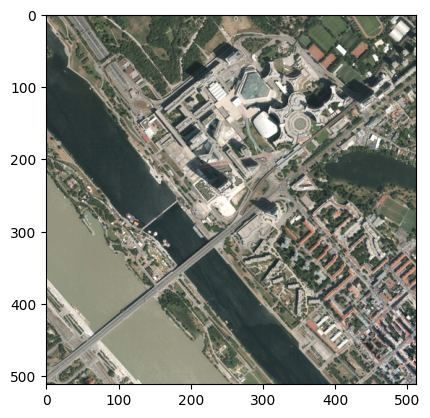

In [12]:
import matplotlib.pyplot as plt
plt.imshow(X_batch[49])

In [34]:
y_batch.shape

(50, 512, 512, 1)

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

input_shape = (512, 512, 3)

inputs = Input(input_shape)

c1 = Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, (3,3), activation="relu", padding="same")(p1)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, (3,3), activation="relu", padding="same")(p2)
p3 = MaxPooling2D((2,2))(c3)

b = Conv2D(512, (3,3), activation="relu", padding="same")(p3)

u1 = UpSampling2D((2,2))(b)
concat1 = Concatenate()([u1, c3])
c4= Conv2D(256, (3,3), activation="relu", padding="same")(concat1)

u2 = UpSampling2D((2,2))(c4)
concat2 = Concatenate()([u2, c2])
c5= Conv2D(128, (3,3), activation="relu", padding="same")(concat2)

u3 = UpSampling2D((2,2))(c5)
concat3 = Concatenate()([u3, c1])
c6= Conv2D(64, (3,3), activation="relu", padding="same")(concat3)

outputs = Conv2D(1, (1,1), activation="sigmoid")(c6)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

2023-09-20 17:44:46.380885: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-09-20 17:44:46.380910: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-09-20 17:44:46.380914: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-09-20 17:44:46.380978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-20 17:44:46.381201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

model.fit(X_batch, y_batch, epochs=20)

Epoch 1/20


2023-09-20 10:13:57.244250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 23s 5s/step - loss: 0.6643 - accuracy: 0.7466
Epoch 2/20
2/2 [==============================] - 16s 5s/step - loss: 0.6611 - accuracy: 0.7468
Epoch 3/20
2/2 [==============================] - 16s 5s/step - loss: 0.5641 - accuracy: 0.7468
Epoch 4/20
2/2 [==============================] - 15s 4s/step - loss: 0.5504 - accuracy: 0.7468
Epoch 5/20
2/2 [==============================] - 15s 4s/step - loss: 0.5422 - accuracy: 0.7468
Epoch 6/20
2/2 [==============================] - 15s 4s/step - loss: 0.5390 - accuracy: 0.7468
Epoch 7/20
2/2 [==============================] - 15s 5s/step - loss: 0.5394 - accuracy: 0.7468
Epoch 8/20
2/2 [==============================] - 14s 4s/step - loss: 0.5370 - accuracy: 0.7468
Epoch 9/20
2/2 [==============================] - 15s 4s/step - loss: 0.5315 - accuracy: 0.7468
Epoch 10/20
2/2 [==============================] - 15s 4s/step - loss: 0.5247 - accuracy: 0.7468
Epoch 11/20
2/2 [==============================] -

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 512, 512, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 256, 256, 64)         0         ['conv2d_12[0][0]']           
 g2D)                                                                                             
                                                                                                  
 conv2d_13 (Conv2D)          (None, 256, 256, 128)        73856     ['max_pooling2d_6[0][0]'

In [25]:
X_new = X_batch[5]
X_new = np.expand_dims(X_new, axis=0)

In [27]:
y_pred = model.predict(X_new)

1/1 [==============================] - 0s 118ms/step


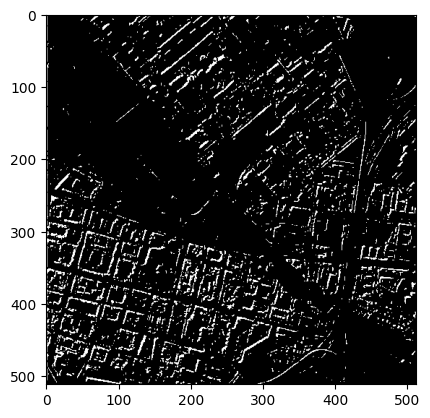

In [35]:
threshold = 0.35
binary_mask = (y_pred > threshold).astype(np.uint8)

# Display the mask
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.show()